## Libraries

In [ ]:
import re
import os
import sys
import ast
import csv
import json
import tweepy
import igraph
import operator
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
from dotenv import load_dotenv
from karateclub import Graph2Vec

load_dotenv()

## Fetch tweet data

In [108]:
class TweetProcessor():
    '''
    A wrapper class for Tweepy.
    Fetches data with tweepy, preprocesses it and saves it as csv.
    Allows search with a keyword or a username.
    '''
    def __init__(self, api_key, api_secret, access_token, access_secret):
        self.auth = tweepy.OAuthHandler(api_key, api_secret)
        self.auth.set_access_token(access_token, access_secret)
        self.api = tweepy.API(self.auth)
        
    def strip_non_ascii(self, string):
        '''Returns a string without the non-ascii characters'''
        stripped = (char for char in string if 0 < ord(char) < 127)
        return ''.join(stripped)

    def write_csv(self, prefix, api_response):
        '''Writes a csv file based on a given api response'''
        fieldnames = [
            'tweet_id', 'tweet_text', 'date', 'user_id',
            'follower_count','retweet_count','user_mentions'
        ]
        with open(f'./data/{prefix.lower()}_tweets.csv', 'w', newline = '') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
            writer.writeheader()
            for tweet in tqdm(api_response):
                text = self.strip_non_ascii(tweet.full_text)
                date = tweet.created_at.strftime('%m/%d/%Y')        
                writer.writerow({
                    'tweet_id': tweet.id_str,
                    'tweet_text': text,
                    'date': date,
                    'user_id': tweet.user.id_str,
                    'follower_count': tweet.user.followers_count,
                    'retweet_count': tweet.retweet_count,
                    'user_mentions': tweet.entities['user_mentions']
                })

    def keyword_search(self, keyword):
        '''Fetches tweets based on the presence of a keyword'''
        api_response = self.api.search(
            q = keyword,
            rpp = 1000,
            show_user = True,
            tweet_mode = 'extended'
        )
        self.write_csv(keyword, api_response)
        
    def user_search(self, user):
        '''Fetches tweets of a given user'''
        api_response = tweepy.Cursor(
            self.api.user_timeline,
            id = user,
            tweet_mode = 'extended'
        )
        self.write_csv(user, api_response.items())

In [109]:
processor = TweetProcessor(
    api_key = os.getenv('API_KEY'),
    api_secret = os.getenv('API_SECRET'),
    access_token = os.getenv('ACCESS_TOKEN'),
    access_secret = os.getenv('ACCESS_SECRET')
)

In [110]:
processor.user_search(user = 'elonmusk')

3218it [01:24, 38.27it/s]


In [111]:
elonmusk_tweets = pd.read_csv('./data/elonmusk_tweets.csv')

elonmusk_tweets.head(3)

,tweet_id,tweet_text,date,user_id,follower_count,retweet_count,user_mentions
0,1299646174874329088,@EvaFoxU @waitbutwhy Yup,08/29/2020,44196397,38336776,24,"[{'screen_name': 'EvaFoxU', 'name': 'Eva Fox 🦊..."
1,1299641513450721280,"@PPathole @ID_AA_Carmack Actually C, although ...",08/29/2020,44196397,38336776,38,"[{'screen_name': 'PPathole', 'name': 'Pranay P..."
2,1299633884129193984,"@ID_AA_Carmack I like C, because it avoids cla...",08/29/2020,44196397,38336776,87,"[{'screen_name': 'ID_AA_Carmack', 'name': 'Joh..."


In [112]:
elonmusk_tweets.loc[1, 'user_mentions']

"[{'screen_name': 'PPathole', 'name': 'Pranay Pathole', 'id': 1291945442, 'id_str': '1291945442', 'indices': [0, 9]}, {'screen_name': 'ID_AA_Carmack', 'name': 'John Carmack', 'id': 175624200, 'id_str': '175624200', 'indices': [10, 24]}]"

## Parse retweets

In [113]:
class RetweetParser():
    '''
    A class for parsing data from a tweets csv file.
    Creates an edge list in the class attribute edge_list.
    '''
    def __init__(self, data, user):
        self.data = data
        self.user = user
        self.edge_list = []

    def write_csv(self, prefix):
        '''
        Writes a csv file based on the created edge list.
        The format is from - to - edge weight.
        '''
        df = pd.DataFrame(parser.edge_list)
        df.columns = ['from_user', 'to_user', 'log_retweet']
        df.to_csv(f'./data/{prefix.lower()}_tweets_edges.csv', index = False)
  
    def create_graph(self):
        '''
        Constructs the edge list of an undirected graph
        for tweets and the user mentions of the tweets.
        Edge weights are based on retweet count.
        '''
        for _, row in tqdm(self.data.iterrows()):
            user_mentions = ast.literal_eval(row[6])
            num_user_mentions = len(user_mentions)
            # if tweet contains user mentions
            if num_user_mentions > 0:
                num_retweets = row[5]
                edge_weight = np.log(num_retweets + 1)
                # iterate over all user mentions of a single tweet 
                for i, mention in enumerate(user_mentions):
                    # add to edge list (tweet user, tweet mention, weight)
                    from_user = self.user
                    to_user = mention['screen_name']
                    self.edge_list.append((from_user, to_user, edge_weight))
                    # also create single edge between all that were mentioned
                    for j in range(i+1, num_user_mentions):
                        from_user = user_mentions[i]['screen_name']
                        to_user = user_mentions[j]['screen_name']
                        self.edge_list.append((from_user, to_user, edge_weight))

        self.write_csv(self.user)

In [114]:
parser = RetweetParser(elonmusk_tweets, 'elonmusk')

parser.create_graph()

3218it [00:00, 6898.22it/s]


In [5]:
elonmusk_edges = pd.read_csv('./data/elonmusk_tweets_edges.csv')

elonmusk_edges.head()

,from_user,to_user,log_retweet
0,elonmusk,EvaFoxU,3.218876
1,EvaFoxU,waitbutwhy,3.218876
2,elonmusk,waitbutwhy,3.218876
3,elonmusk,PPathole,3.663562
4,PPathole,ID_AA_Carmack,3.663562


## Compute eigenvector centralities

In graph theory, eigenvector centrality is a measure of the influence of a node in a network. Relative scores are assigned to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

In [6]:
class TweetGraph():
    '''
    Creates an undirected graph based on the given edge list.
    Computes eigenvector centralities of users and returns those
    as a sorted list.
    '''
    def __init__(self, edge_list):
        self.edges = edge_list.to_records(index = False)
        self.graph = igraph.Graph.TupleList(self.edges, weights = True, directed = False)
        
    def eigen_centrality(self):
        vectors = self.graph.eigenvector_centrality()
        e = {name:c for c, name in zip([v for v in vectors], self.graph.vs['name'])}
        sorted_centralities = sorted(e.items(), key = operator.itemgetter(1),reverse = True)
        return sorted_centralities

In [7]:
elonmusk_graph = TweetGraph(elonmusk_edges)

elonmusk_graph.eigen_centrality()[:20]

[('elonmusk', 1.0),
 ('flcnhvy', 0.4432926657029338),
 ('Erdayastronaut', 0.4300817753402632),
 ('Tesla', 0.393551369722041),
 ('SpaceX', 0.39163650190775434),
 ('PPathole', 0.2843011938425913),
 ('thirdrowtesla', 0.25233297188658554),
 ('teslaownersSV', 0.21141319209657275),
 ('Teslarati', 0.18420633805959472),
 ('Kristennetten', 0.16062698473854276),
 ('NASA', 0.15805338053940943),
 ('SciGuySpace', 0.15137290023458444),
 ('RationalEtienne', 0.12873626168977548),
 ('cleantechnica', 0.12513355490093037),
 ('NASASpaceflight', 0.12313385624003229),
 ('vincent13031925', 0.11006763928045535),
 ('EvaFoxU', 0.09856166894723632),
 ('Space_Station', 0.09189871849586224),
 ('28delayslater', 0.0841759041979091),
 ('AstroBehnken', 0.07417416478291973)]

## Convert to networkx graph

In [53]:
G_elonmusk = nx.Graph()
G_elonmusk.add_weighted_edges_from(elonmusk_graph.edges)

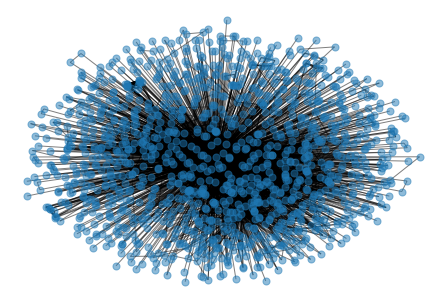

In [50]:
nx.draw(
    G_elonmusk,
    node_size = 50,
    with_labels = False,
    alpha = 0.5
)

In [51]:
G_elonmusk = nx.convert_node_labels_to_integers(G_elonmusk)

## Graph2vec

KarateClub is an unsupervised machine learning extension library for NetworkX. It provides network embedding techniques for nodes and graphs. Graph2vec is a graph-level embedding method. Here we have only a single graph (for user elonmusk) but this process could be iterated over multiple users and the embeddings can be used for supervised learning task.

In [31]:
g2v_model = Graph2Vec(dimensions = 64)

g2v_model.fit([G_elonmusk])

In [32]:
elonmusk_embeddings = pd.DataFrame(g2v_model.get_embedding())

elonmusk_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.531808,-0.616256,-0.070263,-0.445396,-0.335275,-0.320477,0.453445,0.631081,0.329698,0.041213,...,0.140966,0.18396,-0.193699,-0.405471,-0.030422,-0.548779,0.506206,0.500352,-0.537319,0.153758
